### This notebook works on the relation extracted triplets made using REBEL for Knowledge Graphs:

- Head (Node)
- Edge (Relation)
- Tail (Node)

In [1]:
!pip install networkx
!pip install pyvis
!pip install neo4j
!pip install plotly

In [2]:
import os
from google.colab import files
import pandas as pd

In [3]:
uploaded = files.upload()

Saving Neo4j_HeadRelationTail_125-150.csv to Neo4j_HeadRelationTail_125-150 (1).csv


In [4]:
triplet= pd.read_csv('Neo4j_HeadRelationTail_125-150 (1).csv')

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase

In [6]:
triplets = []
for index, row in triplet.iterrows():
    head = row['n']
    relation_type = row['r']
    tail = row['m']
    if head != 'head' and tail != 'tail':
        triplets.append({'head': head, 'type': relation_type, 'tail': tail})

## Using Neo4j
Neo4j is a graph database management system designed to store and manage relationships between data points.
Neo4j is highly efficient for handling complex queries on graph data, such as traversing relationships or identifying patterns within the graph

Here, Neo4j is used to create a knowledge graph by storing extracted triplets in the database, with nodes representing entities and relationships as edges.

In [7]:
from neo4j import GraphDatabase

Connecting to the Neo4j instance

In [8]:
uri = "neo4j+s://6b479450.databases.neo4j.io"  # Replace with your Neo4j instance URI
username = "neo4j"
password = "a-kw5fZ6cRB0oe66mDO5JRrRZ1ynC1ym-IeokE1qq0o"  # Replace with your Neo4j password
driver = GraphDatabase.driver(uri, auth=(username,password))

In [9]:
def create_nodes_and_relationships(tx, head, type_, tail):
    query = (
        "MERGE (a:head {name: $head}) "
        "MERGE (b: tail {name: $tail}) "
        "MERGE (a)-[r : Relation {type: $type}]->(b)"
    )
    tx.run(query, head=head, type=type_, tail=tail)

In [10]:
# def get_graph_data(tx):
#     query = "MATCH (n)-[r]->(m) RETURN n.name AS head, r.type AS type, m.name AS tail"
#     result = tx.run(query)
#     return [(record["head"], record["type"], record["tail"]) for record in result]

In [11]:
with driver.session() as session:
    for row in triplets:
        session.write_transaction(create_nodes_and_relationships, row['head'], row['type'], row['tail'])

print("Knowledge graph created successfully!")

driver.close()

<ipython-input-11-e88334ab5849>:3: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(create_nodes_and_relationships, row['head'], row['type'], row['tail'])


Knowledge graph created successfully!


The graph data is stored within the Neo4j database, where it can be queried and manipulated using Cypher queries. The data isn't exported as a file in this method but remains within the database environment.

### Accessing the graph data:

open the neo4j instance, run the Cypher query
MATCH (n)-[r]->(m)
RETURN n, r, m

Press play button on the screen

## NetworkX
NetworkX is a Python library used for the creation, manipulation, and study of complex networks. Matplotlib is used to visualize these networks.
NetworkX allows you to visualize and analyze the structure of your knowledge graph easily.

Here, NetworkX creates a directed graph (DiGraph) from the extracted triplets, and Matplotlib is used to render and display the graph.

In [12]:
G = nx.DiGraph()

In [13]:
for data in triplets:
    G.add_edge(data['head'], data['tail'], label=data['type'])

In [14]:
pos = nx.spring_layout(G)  # positions for all nodes
labels = nx.get_edge_attributes(G, 'label')

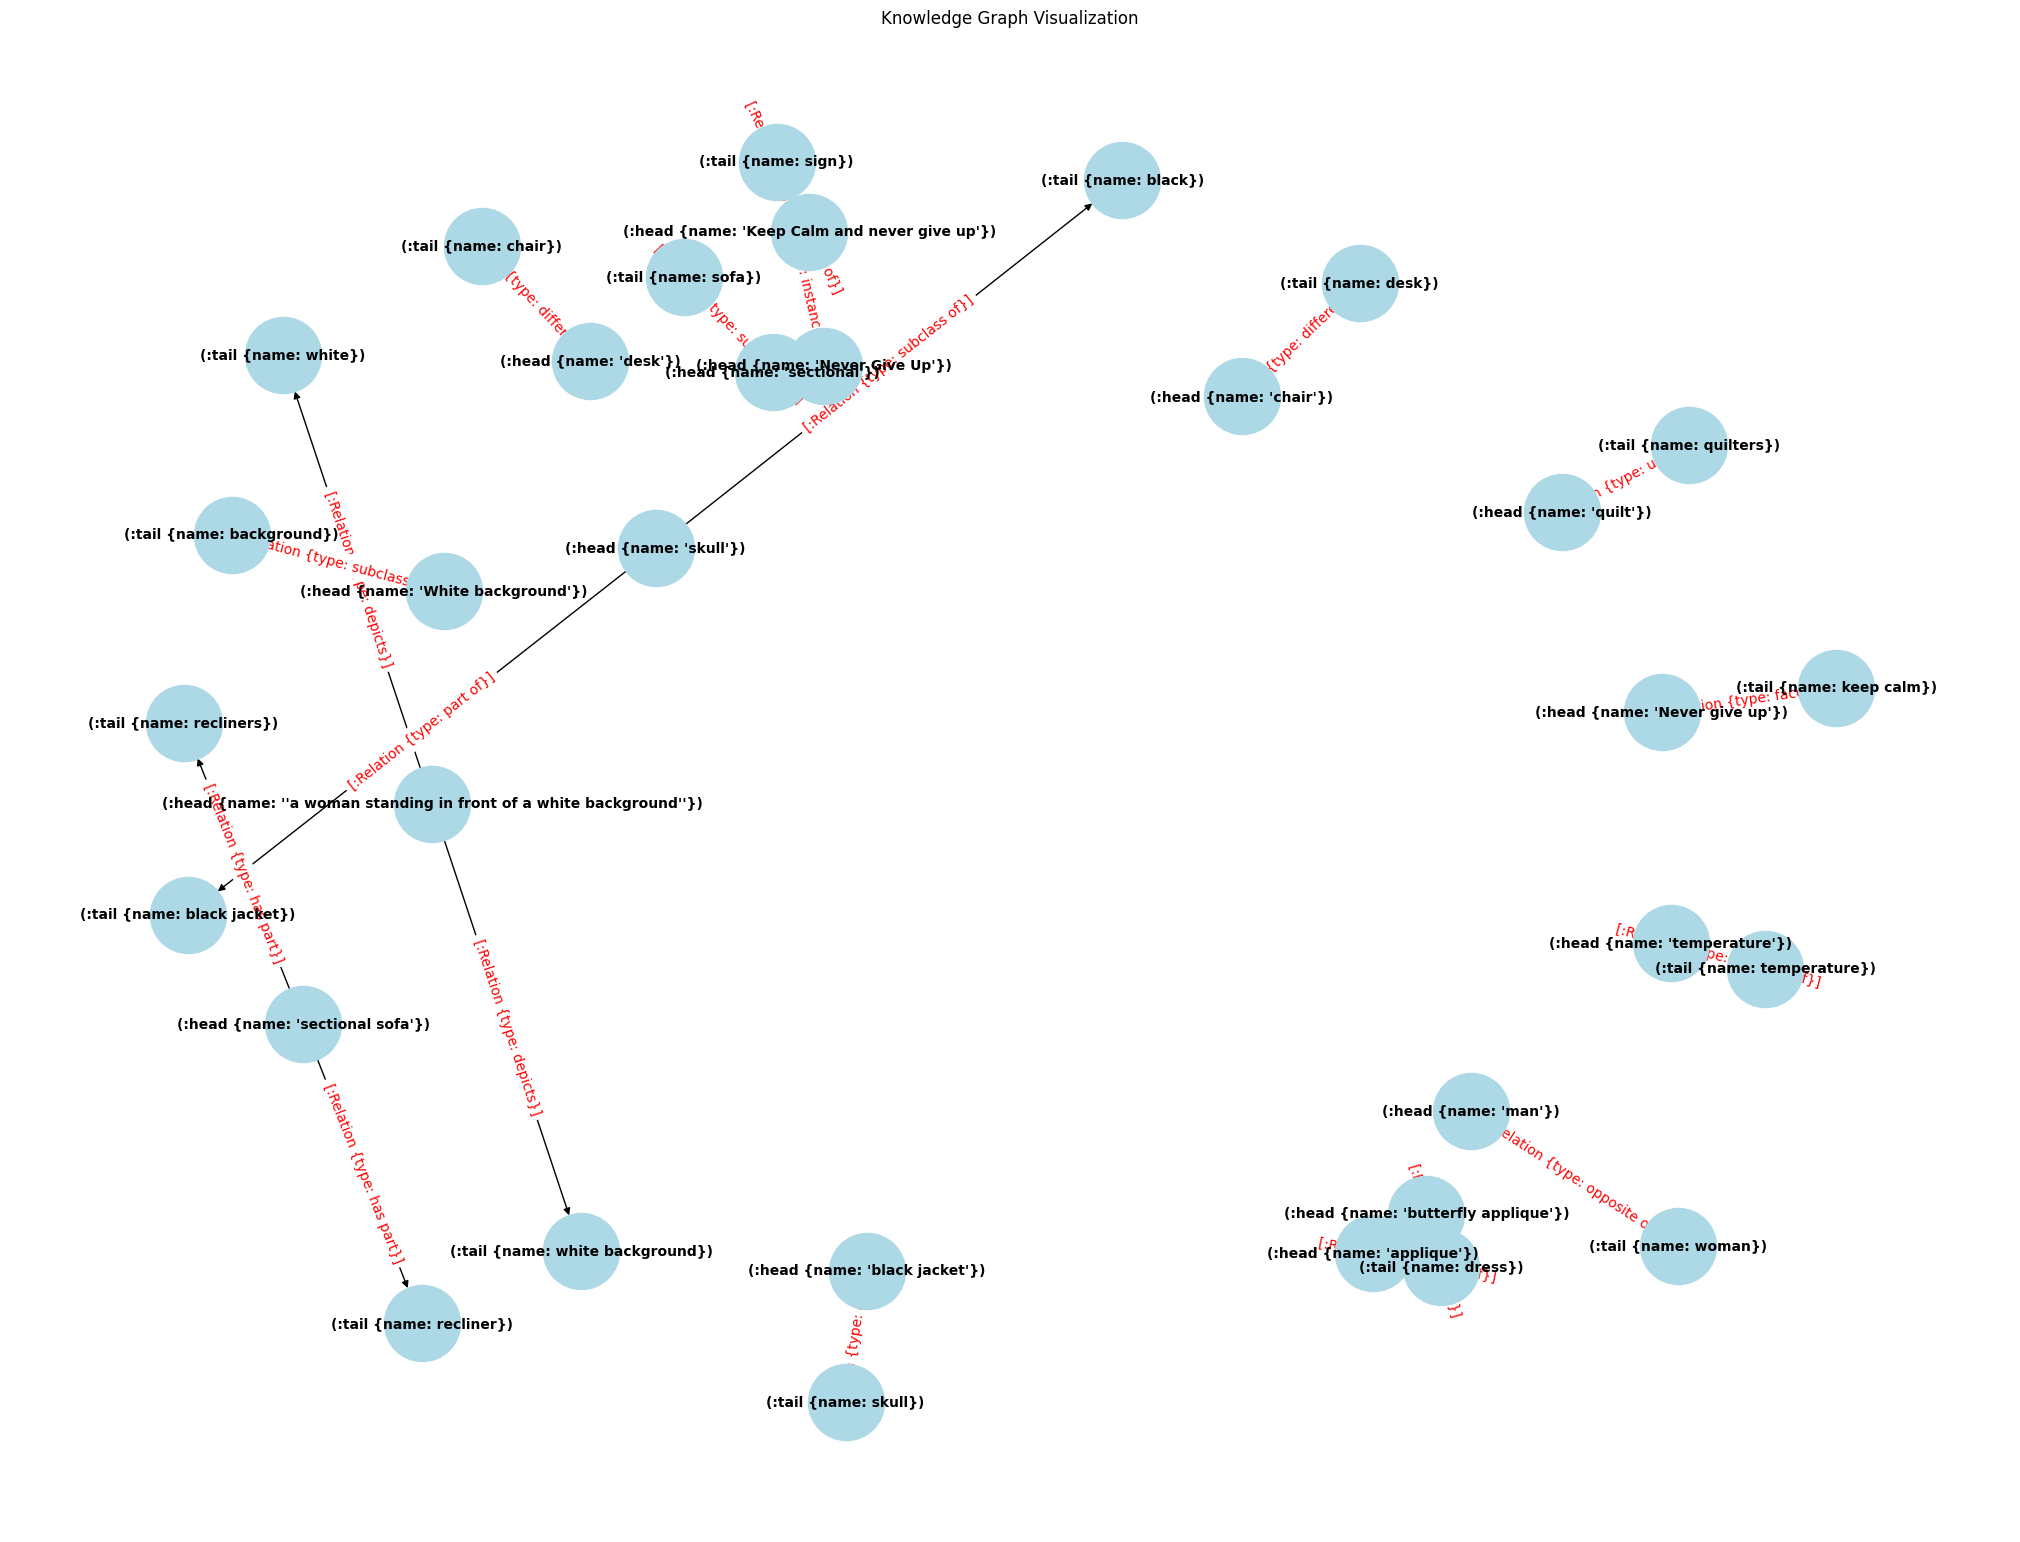

In [15]:
plt.figure(figsize=(20, 15))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

plt.title('Knowledge Graph Visualization')
plt.show()

## Plotly with NetworkX Di-graph

Plotly is an interactive graphing library, and when combined with NetworkX, it allows for the creation of interactive network visualizations. This method is especially useful when you need to interact with the graph data, such as when exploring relationships or debugging the structure of your knowledge graph. 

Here, we use Plotly to generate an interactive graph that can be zoomed, panned, and explored directly in the browser.

In [ ]:
import plotly.graph_objects as go
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for record in triplets:
    G.add_edge(record['head'], record['tail'], label=record['type'])

pos = nx.spring_layout(G)

# Extract edge labels
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=2, color='#888'),
    hoverinfo='none',
    mode='lines')

config = {
    'scrollZoom': True,       # Enable scroll to zoom
    'modeBarButtonsToRemove': [ 'select2d', 'lasso2d',
                                'autoScale2d',
                               'resetScale2d', 'hoverClosestCartesian',
                               'hoverCompareCartesian', 'toggleSpikelines'],
    'displaylogo': True      # Hide the Plotly logo
}


# Extract node labels
node_x = []
node_y = []
for node in pos:
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=[node for node in G.nodes()],
    textposition="bottom center",
    hoverinfo='text',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        size=30,
        line_width=1
    )
)

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network graph made with Plotly',
                titlefont_size=32,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/python/network-graphs/'> link</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False,showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False,showticklabels=False))
                )

fig.update_layout(
    dragmode='zoom',  # Set default dragmode to zoom
    modebar_add=['zoomIn2d', 'zoomOut2d', 'zoom2d','zoomIn2d', 'zoomOut2d']
)

fig.show(config=config)

The graph is displayed interactively in the notebook, with no direct file output.

Layout is spring- you can change to different distribution
- Circular- pos = nx.circular_layout(G)
- Kamada-Kawai Layout- pos = nx.kamada_kawai_layout(G)
- Shell Layout- pos = nx.shell_layout(G)
- Spectral Layout- pos = nx.spectral_layout(G)

## Graphviz
Graphviz is an open-source graph visualization software that uses a description language called DOT. It's useful when you need a static, detailed visualization of your knowledge graph that can be shared or printed.

Here, Graphviz is used to generate a directed graph based on the extracted triplets, which is then rendered and saved.

In [ ]:
from graphviz import Digraph

# Create a Digraph object
dot = Digraph()

# Add nodes and edges to the Digraph
for record in triplets:
    dot.node(record['head'])
    dot.node(record['tail'])
    dot.edge(record['head'], record['tail'], label=record['type'])

# Render and display the graph in the notebook
dot.render('knowledge_graph', view=True)

In [ ]:
files.download('knowledge_graph.pdf')